# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [2]:
!pip install wntr
%matplotlib inline
import wntr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 13.5 MB/s 


In [3]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)

<module 'utils.Dataloader' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Dataloader.py'>

## Main

### Testing

In [4]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


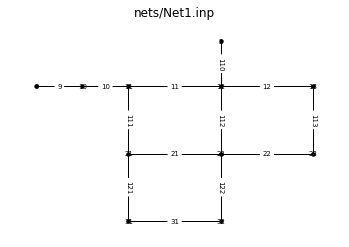

In [5]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()

In [43]:
def gen_single_data(wdn, leakage_node='', end_time=30*24, include_time=False):

  # Labels
  y = np.zeros((end_time+1,))

  # Construct leakages
  leakages = []
  if leakage_node:
    leakage_start = np.random.randint(end_time // 2, end_time * 9 // 10)
    leakage_strength = round(0.0009 + np.random.rand() / 2000, 4)
    leakages.append((leakage_node, leakage_strength, leakage_start+10*24, end_time+10*24))
    y[leakage_start:] = 1
  
  # Run simulation and remove first 10 convergence days
  p = wdn.simulate(end_time+10*24, leakages)[10*24:]
  print(p)

  # Add noise
  noise = np.random.normal(0, 0.15, [len(p), len(wdn.important_nodes)])
  p.loc[:, wdn.important_nodes] = p.loc[:, wdn.important_nodes] + noise
  print(p)

  # Features
  data = Dataloader(p, wdn.important_nodes)
  X = data.get_nodes(include_time=include_time)
  print(X.columns)

  return X, y

In [39]:
def show_data(X, y):
  # Get Leakage time
  leakage_at = round(30*24 - y.sum())
  print('Leakage at', 240+leakage_at, 'Day', leakage_at // 24, 'Hour', leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[240+leakage_at-3*24:leakage_at+240+3*24,:], line_at=[240+leakage_at])

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy)

             10         11         12  ...    9  hour of the day  day
hour                                   ...                           
240   78.655965  78.655965  82.171800  ...  0.0                0   10
241   77.313341  77.313341  80.829175  ...  0.0                1   10
242   75.766103  75.766103  79.469849  ...  0.0                2   10
243   87.529545  81.403030  79.875041  ...  0.0                3   10
244   87.835639  81.750977  80.596313  ...  0.0                4   10
...         ...        ...        ...  ...  ...              ...  ...
956   92.296749  86.824774  85.012612  ...  0.0               20   39
957   92.928204  87.543383  85.815452  ...  0.0               21   39
958   93.323721  87.993549  86.588658  ...  0.0               22   39
959   93.716139  88.440230  87.086974  ...  0.0               23   39
960   93.872967  88.618757  87.581999  ...  0.0                0   40

[721 rows x 13 columns]
             10         11         12  ...    9  hour of the day 

<Figure size 432x288 with 0 Axes>

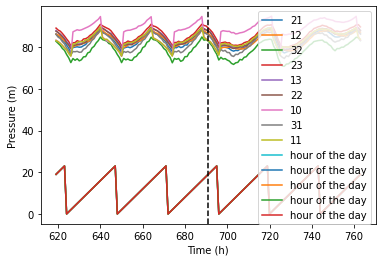

<Figure size 432x288 with 0 Axes>

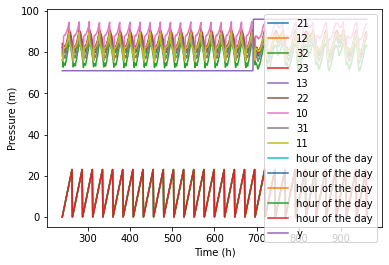

In [45]:
del X
del y
X, y = gen_single_data(wdn, '12', include_time=True)
show_data(X, y)

In [41]:
X.columns

Index(['21', '12', '32', '23', '13', '22', '10', '31', '11', 'hour of the day',
       'hour of the day'],
      dtype='object')

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [37]:
from sklearn import svm

# Create the model
model = svm.SVC(gamma=0.001)

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
y_pred = model.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[109,  12],
       [ 23,  37]])

ohne tod: array([[77, 26],
       [34, 44]])